### Package imports

In [6]:
# Import packages
import re
import os
import copy
from pathlib import Path
import numpy as np
from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence
import pandas as pd
import random
import datetime
import time
from pdb import set_trace
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.mixture import BayesianGaussianMixture
import matplotlib.pyplot as plt
import gc

In [7]:
Set = 'Protein + mRNA' # Change it to 'Protein' if only generating proteome synthetic data

### Set seed function

In [8]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    rs = RandomState(MT19937(SeedSequence(seed)))

### File path

In [9]:
# File path
raw_data_path = '/home/ec2-user/MLNotebook shared/Datasets/Test set raw data/' # for Johansson and Mertins raw data, 
dataset_folder_path = '/home/ec2-user/MLNotebook shared/Datasets/' # for localization label
output_path = '/home/ec2-user/MLNotebook shared/Datasets/'

### Functions

In [15]:
def Bayesian_GMM(PD, MD, Set, Rand_State_1, Rand_State_2, Canvas_Size):

    if Set == 'Protein' or Set == 'Protein + mRNA':
        # Fit the dataset to Bayesian Gaussian Mixture Model
        PD_T = PD.T
        PD_bgm = BayesianGaussianMixture(n_components=2, mean_prior=PD_T.mean(axis=0), weight_concentration_prior=1, random_state=Rand_State_1)
        PD_bgm.fit(PD_T)
    
        # Generate X new synthetic tumors, result is an array
        if Set == 'Protein':
            synthetic_PD, _ = PD_bgm.sample(int(Canvas_Size*Canvas_Size-PD.columns.size))
        elif Set == 'Protein + mRNA':
            synthetic_PD, _ = PD_bgm.sample(int((Canvas_Size*Canvas_Size-PD.columns.size*2)/2))
    
        # Transpose back before merging
        synthetic_PD = synthetic_PD.T

        # Convert the result to a DataFrame
        synthetic_PD = pd.DataFrame(synthetic_PD.tolist(), index=PD.index)

        # Merge the synthetic data with the original data
        PD = pd.concat([PD, synthetic_PD], axis=1)

        # Sanity check for the number of tumors in each dataframe
        
        if Set == 'Protein + mRNA':
            assert len(PD.columns) == Canvas_Size*Canvas_Size // 2
        else:
            assert len(PD.columns) == Canvas_Size*Canvas_Size

        print(f'{Set} - Post-Bayesian PD: {len(PD.columns)}')
      
    if Set == 'mRNA' or Set == 'Protein + mRNA':
        # Fit the dataset to Bayesian Gaussian Mixture Mode
        MD_T = MD.T
        MD_bgm = BayesianGaussianMixture(n_components=2, mean_prior=MD_T.mean(axis=0), weight_concentration_prior=1, random_state=Rand_State_2)
        MD_bgm.fit(MD_T)

        # Generate X new synthetic tumors, result is an array
        if Set == 'mRNA':
            synthetic_MD, _ = MD_bgm.sample(int(Canvas_Size*Canvas_Size-MD.columns.size))
        if Set == 'Protein + mRNA':
            synthetic_MD, _ = MD_bgm.sample(int((Canvas_Size*Canvas_Size-MD.columns.size*2)/2))

        # Transpose back before merging
        synthetic_MD = synthetic_MD.T

        # Convert the result to a DataFrame
        synthetic_MD = pd.DataFrame(synthetic_MD.tolist(), index=MD.index)

        # Merge the synthetic data with the original data
        MD = pd.concat([MD, synthetic_MD], axis=1)
         
        # Sanity check for the number of tumors in each dataframe
        if Set == 'Protein + mRNA':
            assert len(MD.columns) == Canvas_Size*Canvas_Size // 2
        else:
            assert len(MD.columns) == Canvas_Size*Canvas_Size
        print(f'{Set} - Post Bayesian MD: {len(MD.columns)}')

    else:
        print('No synthetic data generated')
    
    return PD, MD

In [11]:
def NormAndStand(df):
    # Unlog the data
    df = 2**df

    # Normalize by gene average for each row
    df = df.divide(df.mean(axis=1), axis=0)

    # Normalize by tumor median for each column
    df = df.divide(df.median(axis=0), axis=1)

    # Log2 transform
    df = np.log2(df)

    # Standarize by gene std for each row
    df = df.divide(df.std(axis=1), axis=0)

    # Find the 2.5th and 97.5th percentile value globally
    lower_bound = np.percentile(df.values, 2.5)
    upper_bound = np.percentile(df.values, 97.5)

    # Normalize using the global percentile values
    df = (df)/(upper_bound-lower_bound)

    return df

In [12]:
def VisualizeData(PD, MD):
    # Create a figure
    plt.figure(figsize=(8, 8))

    # Create a subplot for PD boxplot
    plt.subplot(2, 2, 1)
    plt.boxplot(PD.values)
    plt.title('Proteome')
    plt.xlabel('Tumors')
    plt.ylabel('Abundances')
    plt.xticks([])

    # Create a subplot for MD boxplot
    plt.subplot(2, 2, 2)
    plt.boxplot(MD.values)
    plt.title('Transcriptome')
    plt.xlabel('Tumors')
    plt.ylabel('Abundances')
    plt.xticks([])

    # Create a subplot for PD histogram
    plt.subplot(2, 2, 3)
    plt.hist(PD.values.flatten(), bins=500)
    plt.title('Proteome')
    plt.xlabel('Tumors')
    plt.ylabel('Count')
    plt.xlim([-1.5,1.5])

    # Create a subplot for MD histogram
    plt.subplot(2, 2, 4)
    plt.hist(MD.values.flatten(), bins=500)
    plt.title('Transcriptome')
    plt.xlabel('Tumors')
    plt.ylabel('Count')
    plt.xlim([-1.5,1.5])

    plt.tight_layout()
    plt.show()

### Preparing data for Krug

#### Loading in data

In [ ]:
# Open the proteomics data and only keep genes (rows) that are fully quantified
PFP = 'kr_pro_raw.csv' # proteomics file (genes table) path, normalized by pool, log2 transformed.
PD = pd.read_csv(raw_data_path+PFP)

# Data set wrangling
PD.index = PD.loc[:,'Gene']
PD = PD.loc[:,PD.columns!='Gene']
PD.dropna(inplace=True)

# Specific for krug raw ddamsproteomics, these 3 tumors are not in transcriptome data
PD = PD.loc[:,PD.columns!='X11BR057']
PD = PD.loc[:,PD.columns!='X11BR076']
PD = PD.loc[:,PD.columns!='X11BR078']

# Open the mRNA data and only keep genes (rows) that are fully quantified
MFP = 'kr_rna_raw.csv' # mRNA file path, log2 transformed
MD = pd.read_csv(raw_data_path+MFP)

# Data set wrangling
MD.index = MD.loc[:,'Gene']
MD = MD.loc[:,MD.columns!='Gene']
MD = MD.drop_duplicates()
MD.dropna(inplace=True)

#### Normalization

In [ ]:
PD = NormAndStand(PD)
MD = NormAndStand(MD)

In [ ]:
VisualizeData(PD, MD)

#### Bayesian inference

In [ ]:
# Ensure reproducibility
set_seed(43)

# Generate synthetic data using Bayesian Gaussian Mixture Model
PD, MD = Bayesian_GMM(PD=PD, MD=MD, Set='Protein + mRNA', Rand_State_1=42, Rand_State_2=43, Canvas_Size=18)

In [ ]:
VisualizeData(PD, MD)

#### Filter out genes that has labels

In [ ]:
# Open the labels data
LFP = 'SubCellBarcode.MCF7.txt'
LD = pd.read_csv(filepath_or_buffer=dataset_folder_path+LFP,sep='\t')

# Data set wrangling
LD.index = LD.loc[:,'Protein']
LD = LD.loc[:,LD.columns!='Protein']

# Remove unclassified class
NotUnclassInd = LD.loc[:,'Localization'] != 'Unclassified'
LD = LD.loc[NotUnclassInd,:]

In [ ]:
# Keep only genes (rows) are presented in proteome, mRNA and localization data sets
IntersectingGenes = [value for value in PD.index if ((value in MD.index) & (value in LD.index))]
PD = PD.loc[IntersectingGenes,:]
MD = MD.loc[IntersectingGenes,:]
LD = LD.loc[IntersectingGenes,:]

# Sanity check for the number of genes in each dataframe
print('Krug')
print(len(PD.index))
print(len(MD.index))
print(len(LD.index))

#### Post processing plots

In [ ]:
VisualizeData(PD, MD)

In [16]:
gc.collect()

0

### Preparing data for Johansson

#### Loading in data

In [17]:
# Johansson data set
# Open the proteomics data and only keep genes (rows) that are fully quantified
J_PFP = 'jo_protein_log2.csv' # proteomics file path, normalized by pool, log2 transformed.
J_PD = pd.read_csv(raw_data_path+J_PFP)

# Data set wrangling
J_PD.index = J_PD.loc[:,'Unnamed: 0']
J_PD = J_PD.loc[:,J_PD.columns!='Unnamed: 0']
J_PD.dropna(inplace=True)

# Open the mRNA data and only keep genes (rows) that are fully quantified
J_MFP = 'jo_mrna_dropna.csv' # mRNA file path, gene centric median normalized, log2 transformed
J_MD = pd.read_csv(raw_data_path + J_MFP)

# Data set wrangling
J_MD.index = J_MD.loc[:,'Unnamed: 0']
J_MD = J_MD.loc[:,J_MD.columns!='Unnamed: 0']
J_MD = J_MD.drop_duplicates()
J_MD.dropna(inplace=True)

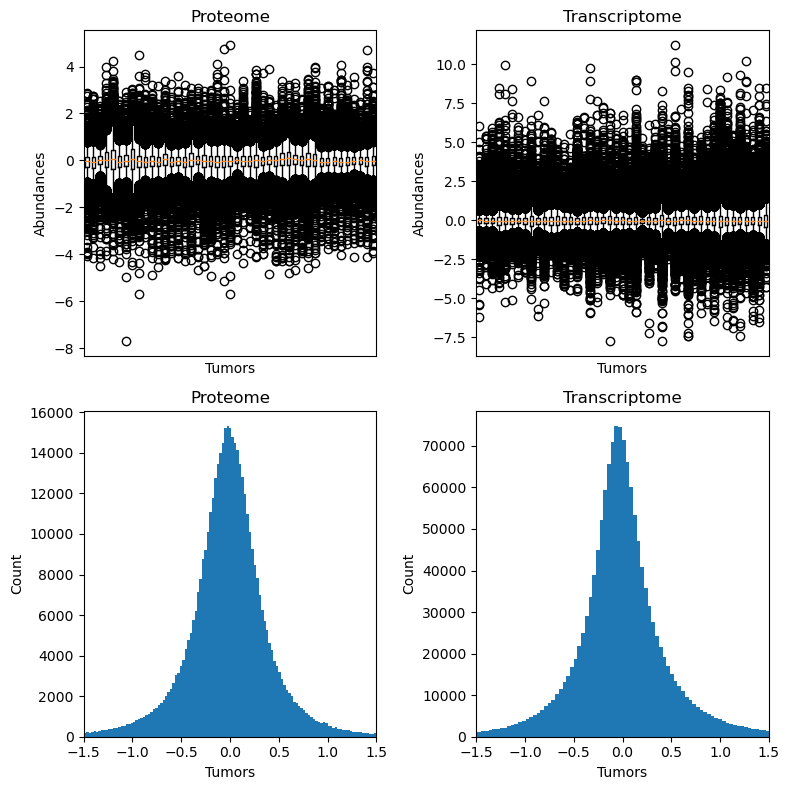

In [18]:
VisualizeData(J_PD, J_MD)

#### Normalization

In [19]:
J_PD = NormAndStand(J_PD)
J_MD = NormAndStand(J_MD)

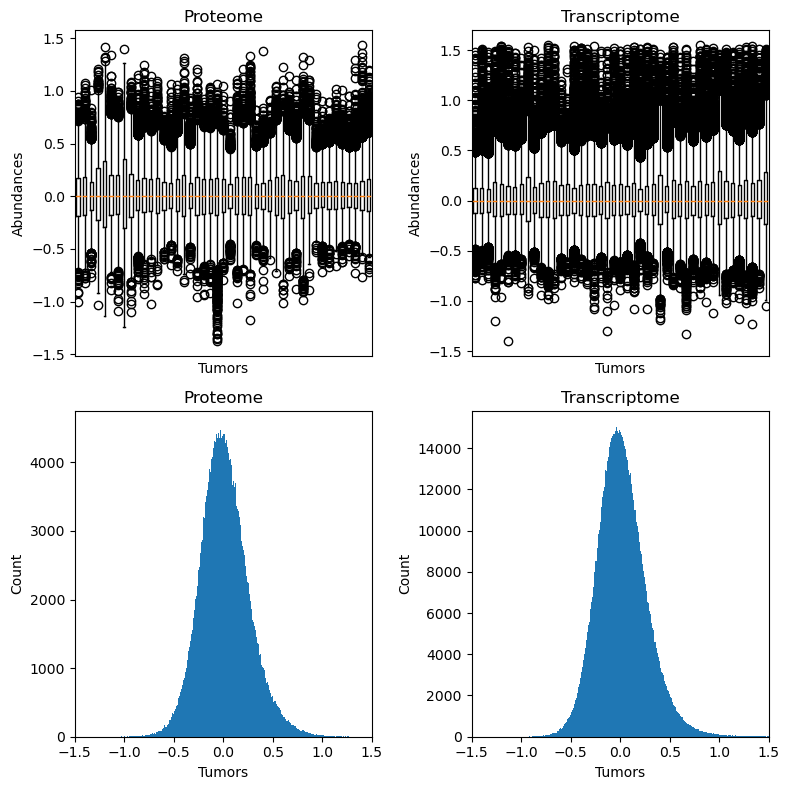

In [20]:
VisualizeData(J_PD, J_MD)

#### Filter out genes that has labels

In [21]:
# Open the localization data
LFP = 'SubCellBarcode.MCF7.txt'
LD = pd.read_csv(filepath_or_buffer=raw_data_path+LFP,sep='\t')

# Data set wrangling
LD.index = LD.loc[:,'Protein']
LD = LD.loc[:,LD.columns!='Protein']

# Remove unclassified class
NotUnclassInd = LD.loc[:,'Localization'] != 'Unclassified'
LD = LD.loc[NotUnclassInd,:]

In [22]:
# Keep only genes (rows) are presented in proteome, mRNA and localization data sets
IntersectingGenes = [value for value in J_PD.index if ((value in J_MD.index) & (value in LD.index))]
J_PD = J_PD.loc[IntersectingGenes,:]
J_MD = J_MD.loc[IntersectingGenes,:]
LD = LD.loc[IntersectingGenes,:]

# Sanity check for the number of genes in each dataframe
print('Johansson')
print(len(J_PD.index))
print(len(J_MD.index))
print(len(LD.index))

Johansson
7989
7989
7989


#### Bayesian inference

In [23]:
set_seed(43)
J_PD, J_MD = Bayesian_GMM(PD=J_PD, MD=J_MD, Set='Protein + mRNA', Rand_State_1=44, Rand_State_2=45, Canvas_Size=18)

Protein + mRNA - Post-Bayesian PD: 162
Protein + mRNA - Post Bayesian MD: 162


#### Post processing plots

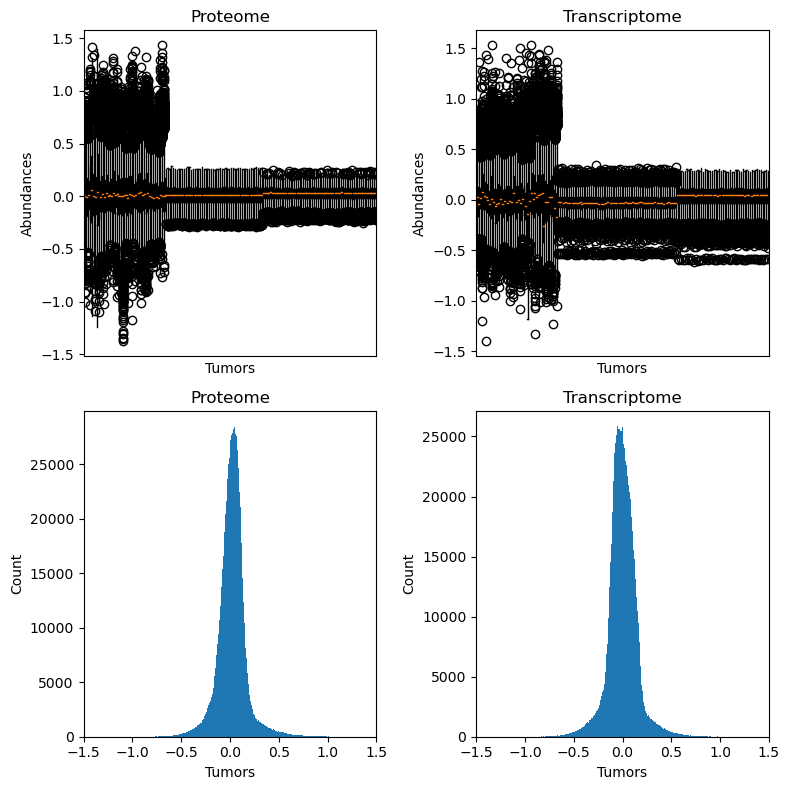

In [24]:
VisualizeData(J_PD, J_MD)

### Preparing data for Mertins

#### Loading in data

In [ ]:
# Mertins data set
# Open the proteomics data and only keep genes (rows) that are fully quantified
M_PFP = 'me_protein_dropna.csv' # proteomics file path, normalized by pool, log2 transformed.
M_PD = pd.read_csv(raw_data_path+M_PFP)

# Data set wrangling
M_PD.index = M_PD.loc[:,'Unnamed: 0']
M_PD = M_PD.loc[:,M_PD.columns!='Unnamed: 0']
M_PD.dropna(inplace=True)

# Open the mRNA data and only keep genes (rows) that are fully quantified
M_MFP = 'me_rna_dropna.csv' # mRNA file path, gene centric median normalized, log2 transformed
M_MD = pd.read_csv(raw_data_path + M_MFP)

# Data set wrangling
M_MD.index = M_MD.loc[:,'Unnamed: 0']
M_MD = M_MD.loc[:,M_MD.columns!='Unnamed: 0']
M_MD = M_MD.drop_duplicates()
M_MD.dropna(inplace=True)

In [ ]:
VisualizeData(M_PD, M_MD)

#### Normalization

In [ ]:
M_PD = NormAndStand(M_PD)
M_MD = NormAndStand(M_MD)

In [ ]:
VisualizeData(M_PD, M_MD)

#### Bayesian inference

In [ ]:
set_seed(43)
M_PD, M_MD = Bayesian_GMM(PD=M_PD, MD=M_MD, Set='Protein + mRNA', Rand_State_1=46, Rand_State_2=47, Canvas_Size=18)

#### Filter out genes that has labels

In [ ]:
# Open the localization data
LFP = 'SubCellBarcode.MCF7.txt'
LD = pd.read_csv(filepath_or_buffer=raw_data_path+LFP,sep='\t')

# Data set wrangling
LD.index = LD.loc[:,'Protein']
LD = LD.loc[:,LD.columns!='Protein']

# Remove unclassified class
NotUnclassInd = LD.loc[:,'Localization'] != 'Unclassified'
LD = LD.loc[NotUnclassInd,:]

In [ ]:
# Keep only genes (rows) are presented in proteome, mRNA and localization data sets
IntersectingGenes = [value for value in M_PD.index if ((value in M_MD.index) & (value in LD.index))]
M_PD = M_PD.loc[IntersectingGenes,:]
M_MD = M_MD.loc[IntersectingGenes,:]
LD = LD.loc[IntersectingGenes,:]

# Sanity check for the number of genes in each dataframe
print('Mertin')
print(len(M_PD.index))
print(len(M_MD.index))
print(len(LD.index))

#### Post processing plots

In [ ]:
VisualizeData(M_PD, M_MD)

### Export

#### Johansson

In [25]:
# export the synthetic data
if Set == 'Protein + mRNA':
    J_PD.to_csv(Path(output_path + 'J_prot+mRNA_PD_synthetic.csv'))
    J_MD.to_csv(Path(output_path + 'J_prot+mRNA_MD_synthetic.csv'))
elif Set == 'Protein':
    J_PD.to_csv(Path(output_path + 'J_prot_PD_synthetic.csv'))
elif Set == 'mRNA':
    J_MD.to_csv(Path(output_path + 'J_mRNA_MD_synthetic.csv'))

#### Krug

In [ ]:
# Export
if Set == 'Protein + mRNA':
    PD.to_csv(Path(output_path + 'K_prot+mRNA_PD_synthetic.csv'))
    MD.to_csv(Path(output_path + 'K_prot+mRNA_MD_synthetic.csv'))
elif Set == 'Protein':
    PD.to_csv(Path(output_path + 'K_prot_PD_synthetic.csv'))
elif Set == 'mRNA':
    MD.to_csv(Path(output_path + 'K_mRNA_MD_synthetic.csv'))

#### Mertins

In [ ]:
# Export
if Set == 'Protein + mRNA':
    M_PD.to_csv(Path(output_path + 'M_prot+mRNA_PD_synthetic.csv'))
    M_MD.to_csv(Path(output_path + 'M_prot+mRNA_MD_synthetic.csv'))
elif Set == 'Protein':
    M_PD.to_csv(Path(output_path + 'M_prot_PD_synthetic.csv'))
elif Set == 'mRNA':
    M_MD.to_csv(Path(output_path + 'M_mRNA_MD_synthetic.csv'))